In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

In [2]:
df_data = pd.read_csv("train_data.csv",header=None)
df_labels = pd.read_csv("train_labels.csv",header=None,names=["label"])
counts = df_labels['label'].value_counts().values
weights = [sum(counts)/(10*count) for count in counts]
weights

[0.20032139577594124,
 0.7059870550161812,
 1.3383435582822085,
 1.678076923076923,
 1.724505928853755,
 2.038785046728972,
 2.237435897435897,
 3.094326241134752,
 4.7423913043478265,
 5.073255813953488]

In [43]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN

def normalize(data):
    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    norm_data = pd.DataFrame(x_scaled)
    return norm_data

def report(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    cm = cm / cm.astype(np.float).sum(axis=1)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.show()
    print(classification_report(y_test, y_pred))

def clean_data(data):
    rhythm = list(range(24*7))
    chroma = list(range(len(rhythm),len(rhythm)+12*4))
    mfcc = list(range(len(chroma)+len(rhythm),len(chroma)+len(rhythm)+12*4))
    #The first 4 columns of MFCC
    remove = np.array([0,1,2,3])
    remove = np.array([remove+i*12 for i in range(4)])
    remove = remove.flatten()
    remove = np.array(mfcc)[remove]
    clean_data = data.drop(remove,axis=1)
    return clean_data

def get_splits(data,labels,test_size=0.4,random_state=0,smote=False):
    X = data.values
    y = labels.label.values
    X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=test_size, random_state=random_state)
    X_train,X_val,y_train,y_val= train_test_split(X_train,y_train, test_size=0.3, random_state=random_state)

    if smote ==False:
        return X_train,X_val,X_test,y_train,y_val,y_test
    sm = SMOTEENN(random_state=random_state)
    
    X_res, y_res = sm.fit_resample(X_train, y_train)
    return X_res,X_val,X_test,y_res,y_val,y_test

def compute_pca(Z, d):
    # Input: the N by D data matrix Z, the number of components d
    # Output: a d by D matrix W_pca, and all eigenvalues of Q
    
    ### STUDENT TASK ###
    
    # step1: compute the sample cov. matrix Q
    # YOUR CODE HERE
    N = Z.shape[0]
    Q = 1/N*(Z.T@Z)
    
    #step2: compute the eigenvalues and eigenvectors (see introduction notebook)
    # YOUR CODE HERE
    values,vectors = np.linalg.eig(Q)

    #step3: Sort the eigenvectors by decreasing eigenvalues, choose the d largest eigenvalues, form W_pca
    # YOUR CODE HERE
    sort  = np.argsort(values)
    largest = sort[-d:][::-1]
    W_pca = vectors[:,largest]
    W_pca = W_pca.T
    eigvalues = values
    
    return W_pca.real,eigvalues

def compression(data,PCA,num_dims):
    data = data.values
    compr = data @ PCA[:num_dims,:].T
    return compr


In [44]:
keras.backend.clear_session()

df_clean = clean_data(data=df_data)
df_clean_norm = normalize(data=df_clean)
df_norm = normalize(data=df_data)

PCA,eigvals = compute_pca(Z=df_norm.values,d=264)

df_comp=pd.DataFrame(compression(data=df_norm,PCA=PCA,num_dims=200))
print(df_comp.shape)


X_train,X_val,X_test, y_train,y_val,y_test = get_splits(data=df_comp,labels=df_labels,test_size = 0.4,random_state=0,smote=False)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4363, 200)
(1831, 200)
(786, 200)
(1746, 200)


In [50]:
N = X_train.shape[1]
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.keras.activations.sigmoid,input_shape=(N,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128,activation=tf.keras.activations.sigmoid),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               25728     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 43,530
Trainable params: 43,530
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [52]:
history = model.fit(X_train, y_train-1, epochs=100,batch_size=32,validation_data=(X_val,y_val-1),class_weight=weights)


Train on 1831 samples, validate on 786 samples
Epoch 1/100
1831/1831 [==============================] - 1s 402us/step - loss: 1.8433 - acc: 0.4489 - val_loss: 1.7461 - val_acc: 0.4796
Epoch 2/100
1831/1831 [==============================] - 0s 104us/step - loss: 1.7215 - acc: 0.4981 - val_loss: 1.7285 - val_acc: 0.4796
Epoch 3/100
1831/1831 [==============================] - 0s 103us/step - loss: 1.6906 - acc: 0.4986 - val_loss: 1.6862 - val_acc: 0.4796
Epoch 4/100
1831/1831 [==============================] - 0s 104us/step - loss: 1.6397 - acc: 0.5030 - val_loss: 1.6689 - val_acc: 0.4796
Epoch 5/100
1831/1831 [==============================] - 0s 123us/step - loss: 1.6031 - acc: 0.5090 - val_loss: 1.5998 - val_acc: 0.4949
Epoch 6/100
1831/1831 [==============================] - 0s 184us/step - loss: 1.5437 - acc: 0.5210 - val_loss: 1.5452 - val_acc: 0.5140
Epoch 7/100
1831/1831 [==============================] - 0s 185us/step - loss: 1.4935 - acc: 0.5483 - val_loss: 1.5152 - val_acc: 0

1831/1831 [==============================] - 0s 106us/step - loss: 0.8891 - acc: 0.7187 - val_loss: 1.1826 - val_acc: 0.6298
Epoch 61/100
1831/1831 [==============================] - 0s 113us/step - loss: 0.8804 - acc: 0.7155 - val_loss: 1.1734 - val_acc: 0.6310
Epoch 62/100
1831/1831 [==============================] - 0s 112us/step - loss: 0.8907 - acc: 0.7111 - val_loss: 1.1735 - val_acc: 0.6247
Epoch 63/100
1831/1831 [==============================] - 0s 119us/step - loss: 0.8840 - acc: 0.7182 - val_loss: 1.1752 - val_acc: 0.6221
Epoch 64/100
1831/1831 [==============================] - 0s 114us/step - loss: 0.8831 - acc: 0.7138 - val_loss: 1.1851 - val_acc: 0.6183
Epoch 65/100
1831/1831 [==============================] - 0s 113us/step - loss: 0.8724 - acc: 0.7078 - val_loss: 1.1825 - val_acc: 0.6272
Epoch 66/100
1831/1831 [==============================] - 0s 115us/step - loss: 0.8792 - acc: 0.7133 - val_loss: 1.1737 - val_acc: 0.6260
Epoch 67/100
1831/1831 [=======================

(1831, 200)


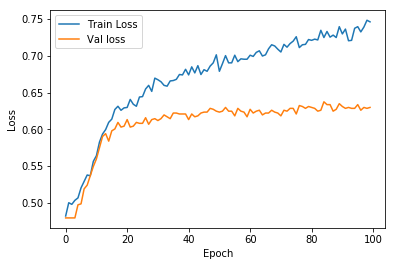

In [48]:
print(X_train.shape)
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['acc']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 1])

plot_history(history)

1746/1746 [==============================] - 0s 14us/step
Score of the model is :  0.6443298971803191
[[784  46  10  16   3  18   0  10   0   0]
 [ 60 130   9  13   0   5   0   0   1   0]
 [ 18  11 100   0   1   3   0   0   2   0]
 [ 31  10   4  48   2   4   1   1   0   0]
 [ 59   7   4   5  13   6   0   2   5   0]
 [ 45  11  12   6   1  27   0   2   4   0]
 [ 27   9   4   2   4   2   0   1   4   0]
 [ 59   1   1   1   3   1   0  11   2   0]
 [  7   3   5   0   0   3   0   0  12   0]
 [ 25   1   0   2   2   1   2   0   1   0]]


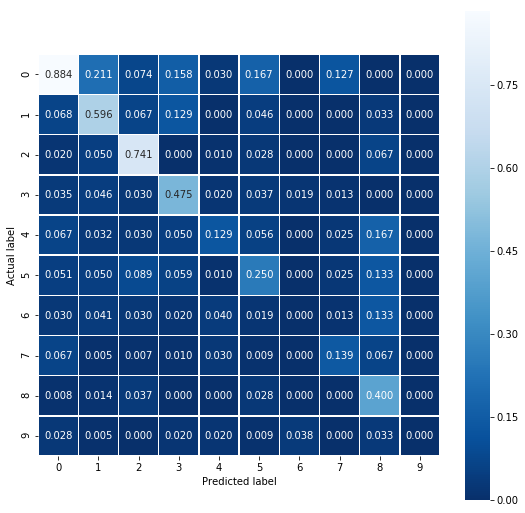

              precision    recall  f1-score   support

           1       0.70      0.88      0.78       887
           2       0.57      0.60      0.58       218
           3       0.67      0.74      0.70       135
           4       0.52      0.48      0.49       101
           5       0.45      0.13      0.20       101
           6       0.39      0.25      0.30       108
           7       0.00      0.00      0.00        53
           8       0.41      0.14      0.21        79
           9       0.39      0.40      0.39        30
          10       0.00      0.00      0.00        34

   micro avg       0.64      0.64      0.64      1746
   macro avg       0.41      0.36      0.37      1746
weighted avg       0.58      0.64      0.60      1746



C:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
df_test=(pd.DataFrame(X_test))
y_pred = model.predict_classes(df_test.values)
print("Score of the model is : ",model.evaluate(X_test,y_test-1)[1])
report(y_pred+1,y_test)

In [77]:
df_kaggle = pd.read_csv('test_data.csv',header=None)
df_kaggle_clean = clean_data(data=df_kaggle)
df_kaggle_norm = normalize(data=df_kaggle_clean)
df_kaggle_norm.shape

(6544, 248)

In [78]:
kaggle_pred = model.predict_classes(df_kaggle_norm.values)
kaggle_pred = kaggle_pred+1
result = pd.DataFrame(data=kaggle_pred,columns=["Sample_label",])
result['Sample_id'] = result.index+1
output = pd.DataFrame()
output['Sample_id'] = result['Sample_id']
output['Sample_label'] = result['Sample_label']
output


,Sample_id,Sample_label
0,1,4
1,2,9
2,3,1
3,4,1
4,5,1
5,6,8
6,7,4
7,8,1
8,9,1
9,10,2


In [79]:
t1 = pd.read_csv('accuracy_solution_22_Oct_1.csv')
t2 = pd.read_csv('accuracy_solution_26_Oct_1.csv')
sum(t1['Sample_label']==output['Sample_label'])
for i in range(1,11):
    print("Sum of class {0} for best: {1} and output is {2}".format(i,sum(t1['Sample_label']==i),sum(output['Sample_label']==i)))


Sum of class 1 for best: 3256 and output is 3368
Sum of class 2 for best: 1142 and output is 774
Sum of class 3 for best: 309 and output is 127
Sum of class 4 for best: 1103 and output is 1656
Sum of class 5 for best: 187 and output is 101
Sum of class 6 for best: 184 and output is 390
Sum of class 7 for best: 97 and output is 1
Sum of class 8 for best: 174 and output is 32
Sum of class 9 for best: 82 and output is 95
Sum of class 10 for best: 10 and output is 0


In [123]:
file_name = "accuracy_solution_26_Oct_3.csv"
output.to_csv(file_name,index=False)